In [3]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
log_dir = "experiment-output/ch6/plain-PDL/train:0.8_rho:0.01_rhomax:5000_alpha:10_L:10-1745660284-6970081/repeat:0"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

        step                            tag       value
0         10      Dual_constraints/eq_resid    2.509600
1         20      Dual_constraints/eq_resid    2.509600
2         30      Dual_constraints/eq_resid    2.509600
3         40      Dual_constraints/eq_resid    2.509600
4         50      Dual_constraints/eq_resid    2.509600
...      ...                            ...         ...
53585   6000  Validation/obj_optimality_gap  156.109375
53586   7000  Validation/obj_optimality_gap  157.104233
53587   8000  Validation/obj_optimality_gap  157.782837
53588   9000  Validation/obj_optimality_gap  158.177185
53589  10000  Validation/obj_optimality_gap  158.541412

[53590 rows x 3 columns]


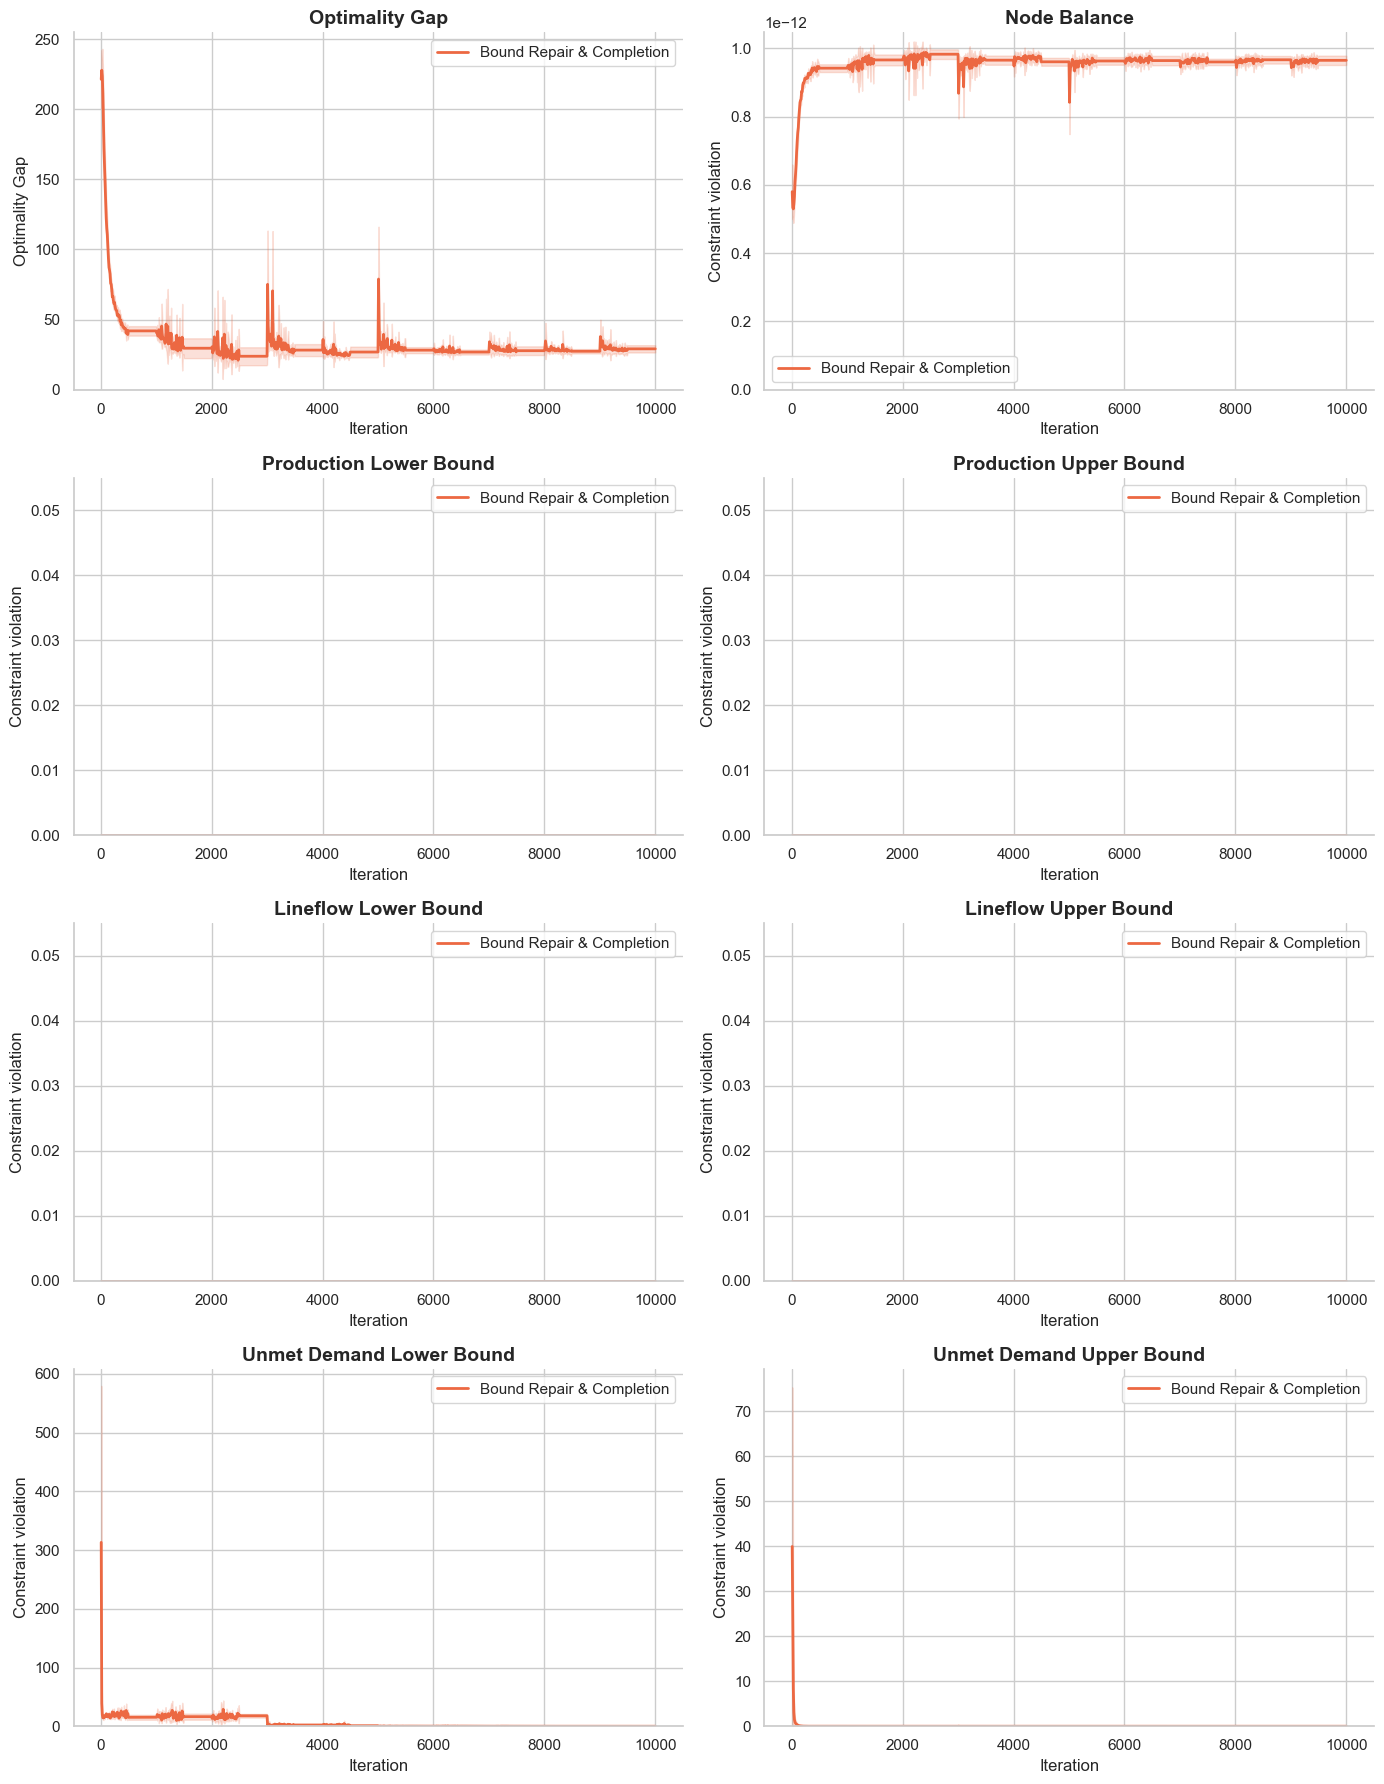

In [19]:
log_dirs = [
    # "experiment-output/ch6/plain-PDL/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746265816-296861",
    "experiment-output/ch6/repair-1/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746429988-424426",
    # "experiment-output/ch6/repair-2/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866"
]
# log_titles = ["Plain", "Bound Repair & Completion", "Node Balance Repair"]  # Custom titles for legend
log_titles = ["Bound Repair & Completion"]

plot_configs = [
    {"tags": ["Train_obj/obj_optimality_gap"], "title": "Optimality Gap", "ylabel": "Optimality Gap", "ylim": 0},
    {"tags": ["Train_constraint_specific/node_balance"], "title": "Node Balance", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/p_gt_lb"], "title": "Production Lower Bound", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/p_gt_ub"], "title": "Production Upper Bound", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/f_lt_lb"], "title": "Lineflow Lower Bound", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/f_lt_ub"], "title": "Lineflow Upper Bound", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/md_nt_lb"], "title": "Unmet Demand Lower Bound", "ylabel": "Constraint violation", "ylim": 0},
    {"tags": ["Train_constraint_specific/md_nt_ub"], "title": "Unmet Demand Upper Bound", "ylabel": "Constraint violation", "ylim": 0}
]

TUDelft_palette = [
    (236/255, 104/255, 66/255),   # Red/orange
    (255/255, 184/255, 28/255),   # Yellow
    (108/255, 194/255, 74/255)    # Green
]

sns.set_theme(style="whitegrid", palette=TUDelft_palette)
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=False)
axes = axes.flatten()

for ax, config in zip(axes, plot_configs):
    for idx, (log_dir, log_title) in enumerate(zip(log_dirs, log_titles)):
        # Collect data from all repeats
        all_repeats_data = []
        for repeat in range(5):  # Assuming 5 repeats
            repeat_dir = os.path.join(log_dir, f"repeat:{repeat}")
            reader = SummaryReader(repeat_dir)
            df = reader.scalars
            for tag in config["tags"]:
                df_tag = df[df['tag'] == tag].sort_values(by='step')
                df_tag['step'] = pd.to_numeric(df_tag['step'])
                # df_tag['value'] = df_tag['value'].clip(lower=1e-4)
                df_tag['repeat'] = repeat  # Add repeat identifier
                all_repeats_data.append(df_tag)
        
        # Combine all repeats data
        if all_repeats_data:
            combined_df = pd.concat(all_repeats_data)
            
            # Use seaborn's built-in errorbar functionality
            sns.lineplot(
                x='step', 
                y='value', 
                data=combined_df, 
                ax=ax, 
                label=log_title, 
                linewidth=2,
                errorbar='sd'  # This will show mean ± standard deviation
            )
    
    ax.set_title(config["title"], fontsize=14, weight='bold')
    ax.set_xlabel('Iteration')
    ax.set_ylabel(config["ylabel"])
    ax.legend()
    # ax.set_yscale('log')
    sns.despine(ax=ax)
    if config["ylim"] is not None:
        ax.set_ylim(config["ylim"])

plt.tight_layout()
plt.savefig("figures/ch6-repair-1.pdf", bbox_inches="tight")
plt.show()